# 合成資料品質檢查 - SDV 0.3.6 版本

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [14]:

"""
數值型欄位評估指標
"""
# KSComplement (Kolmogorov–Smirnov Test 的 1 - D 值）
def ks_complement(real, synthetic):
    stat, _ = ks_2samp(real, synthetic)
    return 1 - stat  # 越接近 1 表示越相似

# RangeCoverage 合成值落在真實資料範圍內的比例）
def range_coverage(real, synthetic):
    min_val, max_val = np.min(real), np.max(real)
    in_range = np.logical_and(synthetic >= min_val, synthetic <= max_val)
    return np.mean(in_range)

# MissingValueSimilarity
def missing_value_similarity(real, synthetic):
    real_ratio = np.mean(pd.isna(real))
    syn_ratio = np.mean(pd.isna(synthetic))
    return 1 - abs(real_ratio - syn_ratio)


# StatisticSimilarity（均值、標準差比對）
def statistic_similarity(real, synthetic):
    real_mean, real_std = np.mean(real), np.std(real)
    syn_mean, syn_std = np.mean(synthetic), np.std(synthetic)
    mean_score = 1 - abs(real_mean - syn_mean) / (abs(real_mean) + 1e-6)
    std_score = 1 - abs(real_std - syn_std) / (abs(real_std) + 1e-6)
    return np.clip((mean_score + std_score) / 2, 0, 1)


"""
類別型欄位評估指標
"""
# TVComplement (Total Variation Distance 的反向）
def tv_complement(real, synthetic):
    real_counts = pd.Series(real).value_counts(normalize=True)
    syn_counts = pd.Series(synthetic).value_counts(normalize=True)
    all_labels = set(real_counts.index).union(syn_counts.index)
    tv = sum(abs(real_counts.get(l, 0) - syn_counts.get(l, 0)) for l in all_labels) / 2
    return 1 - tv

# CategoryCoverage (合成資料有覆蓋多少真實類別）
def category_coverage(real, synthetic):
    real_set = set(real)
    syn_set = set(synthetic)
    return len(syn_set.intersection(real_set)) / len(real_set)

# ContingencySimilarity（交叉表格相似度）
def contingency_similarity(real1, real2, syn1, syn2):
    from sklearn.metrics import mutual_info_score
    real_mi = mutual_info_score(real1, real2)
    syn_mi = mutual_info_score(syn1, syn2)
    return 1 - abs(real_mi - syn_mi) / (real_mi + 1e-6)

"""
序列 & 多欄評估指標
"""
# CorrelationSimilarity（皮爾森相關係數相似度）
def correlation_similarity(real_df, syn_df):
    real_corr = real_df.corr().values
    syn_corr = syn_df.corr().values
    diff = np.abs(real_corr - syn_corr)
    return 1 - np.mean(diff)

# CardinalityShapeSimilarity（類別數量分佈的相似度）
def cardinality_shape_similarity(real, synthetic):
    real_counts = pd.Series(real).value_counts().sort_index()
    syn_counts = pd.Series(synthetic).value_counts().sort_index()
    real_norm = real_counts / real_counts.sum()
    syn_norm = syn_counts / syn_counts.sum()
    all_cats = set(real_counts.index).union(syn_counts.index)
    tv = sum(abs(real_norm.get(c, 0) - syn_norm.get(c, 0)) for c in all_cats) / 2
    return 1 - tv

# SequenceLengthSimilarity（序列長度分佈比對）
def sequence_length_similarity(real_seqs, syn_seqs):
    real_lengths = np.array([len(seq) for seq in real_seqs])
    syn_lengths = np.array([len(seq) for seq in syn_seqs])
    return ks_complement(real_lengths, syn_lengths)

"""
統計綜合：StatisticMSAS（多統計特徵比對平均）
"""
def statistic_msas(real, synthetic):
    scores = [
        statistic_similarity(real, synthetic),
        ks_complement(real, synthetic),
        range_coverage(real, synthetic),
        missing_value_similarity(real, synthetic)
    ]
    return np.mean(scores)


In [15]:
def evaluate_all_columns(real_df, syn_df):
    results = []

    for col in real_df.columns:
        real_col = real_df[col].dropna()
        syn_col = syn_df[col].dropna()

        if pd.api.types.is_numeric_dtype(real_col):
            scores = {
                "KSComplement": ks_complement(real_col, syn_col),
                "RangeCoverage": range_coverage(real_col, syn_col),
                "MissingValueSimilarity": missing_value_similarity(real_col, syn_col),
                "StatisticSimilarity": statistic_similarity(real_col, syn_col),
                "StatisticMSAS": statistic_msas(real_col, syn_col)
            }
        else:
            scores = {
                "TVComplement": tv_complement(real_col, syn_col),
                "CategoryCoverage": category_coverage(real_col, syn_col),
                "CardinalityShapeSimilarity": cardinality_shape_similarity(real_col, syn_col)
            }

        for metric, score in scores.items():
            results.append({"column": col, "metric": metric, "score": score})

    return pd.DataFrame(results)

In [34]:
def compare_numeric_columns(real_df, syn_df, column, bins=30):
    real_vals = real_df[column].dropna()
    syn_vals = syn_df[column].dropna()

    # 計算 KSComplement
    stat, _ = ks_2samp(real_vals, syn_vals)
    ks_score = 1 - stat

    plt.figure(figsize=(8, 4))
    plt.hist(real_vals, bins=bins, alpha=0.5, label='Real', density=True)
    plt.hist(syn_vals, bins=bins, alpha=0.5, label='Synthetic', density=True)
    plt.title(f"{column} Distribution\nKSComplement: {ks_score:.4f}")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [35]:
def compare_categorical_columns(real_df, syn_df, column):
    real_counts = pd.Series(real_df[column]).value_counts(normalize=True)
    syn_counts = pd.Series(syn_df[column]).value_counts(normalize=True)
    categories = sorted(set(real_counts.index).union(syn_counts.index))

    real_vals = [real_counts.get(cat, 0) for cat in categories]
    syn_vals = [syn_counts.get(cat, 0) for cat in categories]

    # 計算 TVComplement
    tv = sum(abs(r - s) for r, s in zip(real_vals, syn_vals)) / 2
    tv_score = 1 - tv

    x = np.arange(len(categories))
    width = 0.35

    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, real_vals, width, label='Real')
    plt.bar(x + width/2, syn_vals, width, label='Synthetic')
    plt.xticks(x, categories, rotation=45)
    plt.title(f"{column} Distribution\nTVComplement: {tv_score:.4f}")
    plt.ylabel("Proportion")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 產出真實資料與合成資料品質比較報告

In [36]:
## inputs
real_data = pd.read_csv("input/data.csv")  ## 真實資料路徑
synthetic_data = pd.read_csv("output/data_GaussianCopula_output.csv") ## 合成資料路徑

syndata_eval_df = evaluate_all_columns(real_data, synthetic_data)  # 注意順序！ 真實資料放前面，合成資料放後面

### 視覺化比較真實 v.s. 合成資料的特定數值欄位

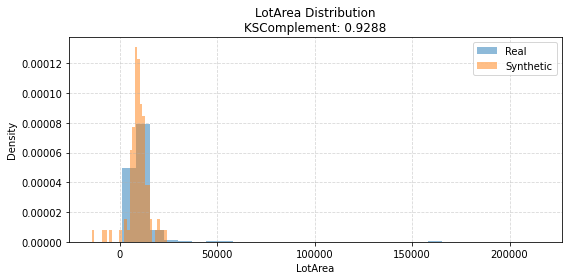

In [37]:
compare_numeric_columns(real_data, synthetic_data, column="LotArea")

### 視覺化比較真實 v.s. 合成資料的特定類別欄位

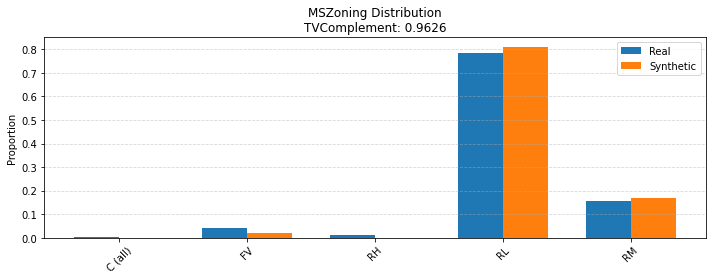

In [38]:
compare_categorical_columns(real_data, synthetic_data, column="MSZoning")

In [18]:
# 整理欄位的平均分數（越低越值得關注）
low_quality_columns = (
    syndata_eval_df
    .groupby("column")["score"]
    .mean()
    .sort_values()
    .reset_index()
)

print("💔 合成品質最差的前 10 欄位：")
print(low_quality_columns.head(10))


💔 合成品質最差的前 10 欄位：
          column     score
0         PoolQC  0.444444
1        MiscVal  0.482500
2       PoolArea  0.490000
3             Id  0.528591
4      3SsnPorch  0.547559
5     BsmtFinSF2  0.618857
6  EnclosedPorch  0.633460
7       SaleType  0.696933
8    MiscFeature  0.700000
9   LowQualFinSF  0.728925


In [19]:
threshold = 0.7
low_scores = syndata_eval_df[syndata_eval_df["score"] < threshold]

print(f"⚠️ 分數低於 {threshold} 的指標：")
display(low_scores.sort_values(by="score"))

⚠️ 分數低於 0.7 的指標：


,column,metric,score
296,MiscVal,StatisticSimilarity,0.000000
282,PoolArea,StatisticSimilarity,0.000000
0,Id,KSComplement,0.065925
3,Id,StatisticSimilarity,0.068439
272,3SsnPorch,StatisticSimilarity,0.114825
291,MiscFeature,CategoryCoverage,0.250000
51,Condition2,CategoryCoverage,0.285714
285,PoolQC,CategoryCoverage,0.333333
80,RoofStyle,CategoryCoverage,0.333333
309,SaleType,CategoryCoverage,0.333333


/home/ubuntu/prjt-synthetic-data/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129514 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/prjt-synthetic-data/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/prjt-synthetic-data/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/prjt-synthetic-data/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21697 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/prjt-synthetic-data/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36074 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubu

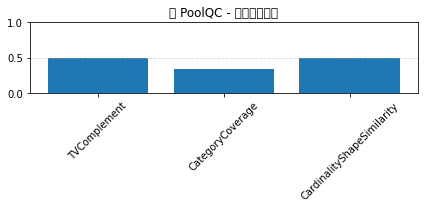

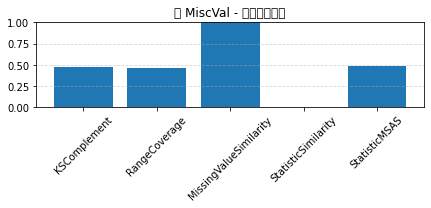

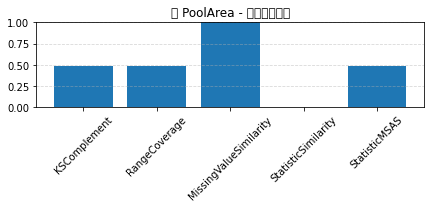

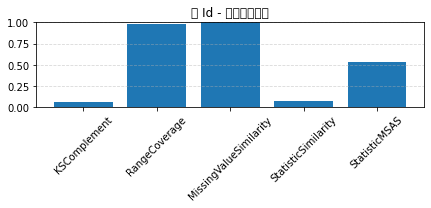

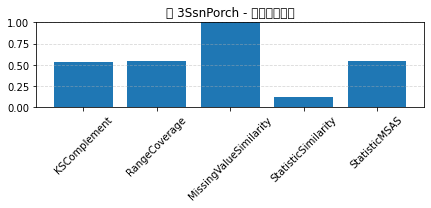

In [22]:
import matplotlib.pyplot as plt

def plot_lowest_score_columns(results_df, top_n=5):
    low_avg = (
        results_df.groupby("column")["score"]
        .mean()
        .sort_values()
        .head(top_n)
    )

    for col in low_avg.index:
        col_scores = results_df[results_df["column"] == col]
        plt.figure(figsize=(6, 3))
        plt.bar(col_scores["metric"], col_scores["score"])
        plt.title(f"🧪 {col} - 合成品質指標")
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# 使用範例
plot_lowest_score_columns(syndata_eval_df, top_n=5)